In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats

from datetime import datetime

from fancyimpute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, PolynomialFeatures 

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from statsmodels.formula import api as smf

Using TensorFlow backend.


In [2]:
## Global Variables
dataset_publish_date = 'May-2019'
test_data_size = 0.15
number_of_splits = 3

# Custom Methods

In [3]:
def get_missing_value_count(data,feature):
    return (data[data[feature].isna() == True].shape[0]/data[feature].shape[0])*100

In [4]:
def encode_categorical_variable(data, feature):
    oe = OrdinalEncoder()
    data[feature] = oe.fit_transform(np.array(data[feature].astype(str)).reshape(-1, 1))
    return data[feature]

In [5]:
def impute_by_constant(data, feature, const_value):
    return data[feature].fillna(const_value)

In [6]:
def impute_by_mice(data, feature, data_type):
    if data_type == 'float':
        return IterativeImputer().fit_transform(np.array(data[feature].astype(float)).reshape(-1, 1))
    elif data_type == 'str':
        return IterativeImputer().fit_transform(np.array(data[feature].astype(str)).reshape(-1, 1))

In [7]:
def impute_by_knn(data, neighbors):
    features = data.columns
    temp_df = KNNImputer(n_neighbors=neighbors).fit_transform(data) #imputation returns nd-array
    return pd.DataFrame(temp_df, columns=features) #convert nd-array to series

In [8]:
def scale_variable(dataset, target_var):
    #separate the target variable
    dataset = loan_data.copy()
    target = dataset[target_var]
    dataset.drop([target_var], axis=1, inplace=True)
    #scaling of features
    scaler = StandardScaler()
    scaler.fit(dataset)
    dataset = pd.DataFrame(scaler.transform(dataset), columns=dataset.columns)
    #add target back to dataset
    dataset[target_var] = target.reset_index().drop(['index'], axis=1)[target_var]
    return dataset

In [9]:
def variable_scale_analysis(dataset, features, graph_name):
    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.set_title(graph_name)
    for feature in features:
        print(feature, ' : ', dataset[feature].dtype)
        sns.kdeplot(dataset[feature], ax=ax1, cumulative=True, bw=1.5)
    plt.show()

In [10]:
# Binning of dependent variable into categories: Good, Bad and Current loan
def loan_type(status):
    bad_loan = ['Charged Off', 'Default', 'Late (31-120 days)']
    current_loan = ['Current', 'In Grace Period', 'Late (16-30 days)']
    if status in bad_loan:
        return 0
        #return 'Bad Loan'
    elif status in current_loan:
        return 2
        #return 'Current Loan'
    else:
        return 1
        #return 'Good Loan'

In [11]:
def count_number_of_months(given_date):
    end_date = datetime.strptime(dataset_publish_date, '%b-%Y')
    start_date = datetime.strptime(given_date, '%b-%Y')
    return (end_date.year - start_date.year)*12 + (end_date.month - start_date.month)

In [12]:
def get_heat_map(data, features, x_size, y_size, title):
    f, ax = plt.subplots(figsize=(x_size, y_size))
    corr = data[features].corr()
    ax = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
                     cmap=sns.diverging_palette(240,10,as_cmap=True), 
                     annot=True, vmin=-1, vmax=1)
    ax.set_title(title)

In [13]:
def get_rmse_score(pred, test):
    mse = np.mean((pred-test)**2)
    rmse = math.sqrt(mse)
    return rmse

In [14]:
def get_adjusted_r_squared(r_sqd, N, p):
    return 1-(((1-r_sqd)*(N-1))/(N-p-1))

# Read dataset

In [15]:
loan_data = pd.read_csv('datasets/LendingClub/AcceptedLoans_2007_to_2018.csv', low_memory=False)
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


# Preprocessing the data

In [16]:
indices_to_be_dropped = loan_data[loan_data['id'].str.contains('Total amount funded in policy code')].index
loan_data.drop(index=indices_to_be_dropped, axis=0, inplace=True)

indices_to_be_dropped = loan_data[loan_data['id'].str.contains('Loans that do not meet the credit policy')].index
loan_data.drop(index=indices_to_be_dropped, axis=0, inplace=True)

In [17]:
loan_data['loan_status'] = loan_data['loan_status'].replace(to_replace='Does not meet the credit policy. Status:Fully Paid', 
                                                  value='Fully Paid')
loan_data['loan_status'] = loan_data['loan_status'].replace(to_replace='Does not meet the credit policy. Status:Charged Off', 
                                                  value='Charged Off')

In [18]:
loan_data = loan_data[loan_data['loan_status'] == 'Charged Off']

In [19]:
loan_data['issue_d'] = (pd.to_datetime(loan_data['issue_d']).dt.year).astype(int)

In [20]:
loan_data['emp_length'].fillna(value=0,inplace=True)
loan_data['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
loan_data['emp_length'] = loan_data['emp_length'].astype(int)
loan_data['emp_length'].replace(to_replace=0, value=np.nan, inplace=True)

**Handling variables specific to currently active loans**

In [21]:
loan_data['last_credit_pull_d'] = impute_by_constant(loan_data, 'last_credit_pull_d', 'May-2019').apply(count_number_of_months)
loan_data['last_pymnt_d'] = impute_by_constant(loan_data, 'last_pymnt_d', 'May-2019').apply(count_number_of_months)

In [22]:
print('Now, the dataset has ', loan_data.shape[0], ' records and ', loan_data.shape[1], ' variables.')

Now, the dataset has  269320  records and  151  variables.


**Create sample from dataset (for dev purpose only)**

In [23]:
'''
loan_data = loan_data.sample(n=round(0.1*loan_data.shape[0]))
print('The sampled dataset has ',loan_data.shape[0],' records and ',loan_data.shape[1],' variables.')
'''

"\nloan_data = loan_data.sample(n=round(0.1*loan_data.shape[0]))\nprint('The sampled dataset has ',loan_data.shape[0],' records and ',loan_data.shape[1],' variables.')\n"

# Feature Engineering

**Dropping features having redundant data, too many missing values and high correlation with other features**

In [24]:
cols_to_be_dropped = ['loan_status','acc_now_delinq','all_util','application_type','desc','earliest_cr_line','emp_title','fico_range_low',
                      'funded_amnt_inv','grade','id','il_util','inq_fi','installment','title','loan_amnt','max_bal_bc','member_id','num_tl_120dpd_2m',
                      'num_tl_op_past_12m','open_acc_6m','open_il_24m','open_rv_24m','out_prncp_inv','pymnt_plan','tot_cur_bal','total_bal_il',
                      'total_pymnt_inv','total_rec_int','total_rec_late_fee','url','zip_code','sec_app_earliest_cr_line','hardship_type','deferral_term',
                      'hardship_length','disbursement_method','last_pymnt_amnt','mths_since_last_major_derog','mths_since_last_record','mths_since_rcnt_il',
                      'mths_since_recent_bc_dlq','mths_since_recent_revol_delinq','next_pymnt_d', 'open_il_12m','open_act_il','open_rv_12m','total_cu_tl',
                      'revol_bal_joint','policy_code','collection_recovery_fee','num_rev_tl_bal_gt_0','int_rate','sec_app_fico_range_low',
                      'sec_app_fico_range_high','sec_app_inq_last_6mths','sec_app_mort_acc','sec_app_open_acc','sec_app_revol_util','sec_app_open_act_il',
                      'sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths','sec_app_collections_12_mths_ex_med','sec_app_mths_since_last_major_derog',
                      'hardship_reason','hardship_status','hardship_amount','hardship_start_date','hardship_end_date','payment_plan_start_date',
                      'hardship_dpd','hardship_loan_status','orig_projected_additional_accrued_interest','hardship_payoff_balance_amount',
                      'hardship_last_payment_amount','debt_settlement_flag','debt_settlement_flag_date','settlement_status','settlement_date',
                      'settlement_amount','settlement_percentage','settlement_term','last_fico_range_low','loan_status']

In [25]:
loan_data.drop(cols_to_be_dropped, axis=1, inplace=True)

In [26]:
print('Now, the dataset has ', loan_data.shape[0], ' records and ', loan_data.shape[1], ' variables.')

Now, the dataset has  269320  records and  68  variables.


**Handling Missing Values (using zero imputation)**

In [27]:
cols_for_zero_imputation = ['acc_open_past_24mths','annual_inc_joint','chargeoff_within_12_mths','collections_12_mths_ex_med','delinq_2yrs','dti_joint',
                            'num_tl_30dpd','num_tl_90g_dpd_24m','open_acc','total_bc_limit','total_il_high_credit_limit', 'delinq_amnt', 'total_acc',
                            'mo_sin_old_il_acct','num_il_tl','tot_coll_amt','mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mths_since_last_delinq',
                            'mths_since_recent_bc','mths_since_recent_inq','mort_acc','num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats',
                            'num_bc_tl','num_op_rev_tl','num_rev_accts','num_sats','pct_tl_nvr_dlq','percent_bc_gt_75','revol_util']

In [28]:
for feature in cols_for_zero_imputation:
    loan_data[feature] = impute_by_constant(loan_data, feature, 0)

**Handling Missing Values (using median imputation)**

In [29]:
cols_for_median_imputation = ['annual_inc','dti','total_rev_hi_lim','avg_cur_bal','tot_hi_cred_lim','bc_open_to_buy',
                              'bc_util','total_bal_ex_mort']

In [30]:
for feature in cols_for_median_imputation:
    loan_data[feature] = impute_by_constant(loan_data, feature, loan_data[feature].median())

**Handling Missing Values (using mode imputation)**

In [31]:
cols_for_mode_imputation = []

**Encoding categorical features**

In [32]:
cols_for_encoding = ['term','sub_grade','home_ownership','verification_status','purpose','addr_state',
                     'initial_list_status','hardship_flag']

In [33]:
for feature in loan_data.columns:
    if loan_data[feature].dtype == 'object':
        loan_data[feature] = encode_categorical_variable(loan_data, feature)

**Handling Missing Values (using knn imputation)**

In [34]:
cols_for_knn_imputation = ['emp_length', 'inq_last_12m', 'inq_last_6mths', 'pub_rec_bankruptcies','tax_liens',
                           'pub_rec']

In [35]:
#X = impute_by_knn(X, 4)

In [36]:
## knn imputation throwing error. hence applied mode imputation
for feature in cols_for_knn_imputation:
    loan_data[feature] = impute_by_constant(loan_data, feature, loan_data[feature].mode().get(0))

**Handling Missing Values (using 'missing' indicator imputation in categorical variables)**

In [37]:
loan_data['verification_status_joint'] = impute_by_constant(loan_data, 'verification_status_joint', 'Not Applicable')

**Feature Scaling**

In [38]:
loan_data_scaled = scale_variable(loan_data, 'recoveries')

# Modelling Preparation

**Dropping columns as per feature selection results from previous tests**

In [39]:
'''
cols_dropped_post_feature_selection = []
loan_data.drop(cols_dropped_post_feature_selection, axis=1, inplace=True)
'''

'\ncols_dropped_post_feature_selection = []\nloan_data.drop(cols_dropped_post_feature_selection, axis=1, inplace=True)\n'

**Get the feature and target variables**

In [40]:
y = loan_data['recoveries']
X = loan_data.drop(['recoveries'], axis=1)

y_scaled = loan_data_scaled['recoveries']
X_scaled = loan_data_scaled.drop(['recoveries'], axis=1)

print('Now, the dataset has ', X.shape[0], ' records and ', X.shape[1], ' variables.')

Now, the dataset has  269320  records and  67  variables.


**Define k for cross-validation**

In [41]:
skf = StratifiedKFold(n_splits=number_of_splits)
n_split = skf.get_n_splits(X)

**Determine the coefficients**

In [42]:
data_train = pd.concat([X_scaled, y_scaled], axis=1)
regressors = ''
regressors_list = list(X_scaled.columns) 
for idx in np.arange(0, len(regressors_list)):
    if idx == len(regressors_list) - 1:
        regressors = regressors + regressors_list[idx]
    else:
        regressors = regressors + regressors_list[idx] + '+'

regressors = 'recoveries ~ ' + regressors

lm1 = smf.ols(formula= regressors, data = data_train).fit()
lm1.params
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:             recoveries   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                 1.019e+04
Date:                Sun, 14 Jun 2020   Prob (F-statistic):               0.00
Time:                        20:08:04   Log-Likelihood:            -2.2407e+06
No. Observations:              269320   AIC:                         4.482e+06
Df Residuals:                  269254   BIC:                         4.482e+06
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

# Data Modelling - Linear Regression

**Modelling: Train, Test and Model Assessment**

In [43]:
## split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_scaled,test_size=test_data_size,random_state=0)
## model fitting using train data
lin_reg = LinearRegression(normalize=True, n_jobs=4)
lin_reg.fit(X_train, y_train)
## predicting using test data
y_pred = lin_reg.predict(X_test)

**Assessing the model performance**

In [44]:
print('The model intercept: ', lin_reg.intercept_)
print('The model prediction score (r^2): ', lin_reg.score(X_test, y_test))
print('The model prediction score (adjusted r^2): ', get_adjusted_r_squared(r_sqd=lin_reg.score(X_test, y_test), 
                                                                            N=X_test.shape[0],
                                                                            p=X_test.shape[1]))
print('The model RMSE score: ', get_rmse_score(y_pred, y_test))

The model intercept:  1207.5578815485303
The model prediction score (r^2):  0.7082927402015445
The model prediction score (adjusted r^2):  0.7078081285872004
The model RMSE score:  1000.6877853389628


Text(0.5, 1.0, 'Actual vs Predicted Values')

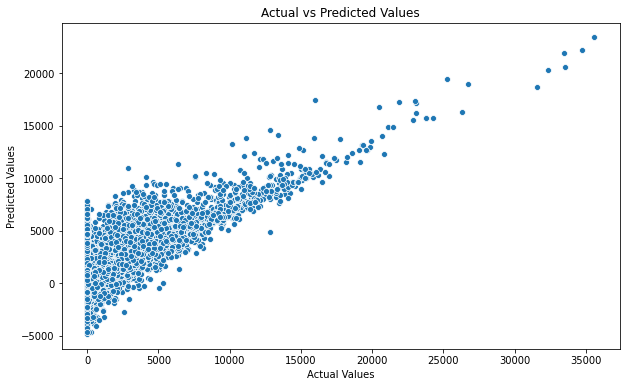

In [45]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x=y_test, y=y_pred)
ax.set(xlabel='Actual Values', ylabel='Predicted Values')
ax.set_title('Actual vs Predicted Values')

# Data Modelling - Polynomial Regression

**Modelling: Train, Test and Model Assessment**

In [46]:
## define the polynomial degree
poly = PolynomialFeatures(degree=2,include_bias=False)
X_poly = poly.fit_transform(X_scaled)
## split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_poly,y_scaled,test_size=test_data_size,random_state=0)
## model fitting using train data
poly_reg = LinearRegression(normalize=True, n_jobs=4)
poly_reg.fit(X_train, y_train)
## predicting using test data
y_pred = poly_reg.predict(X_test)

In [47]:
print('The model intercept: ', poly_reg.intercept_)
print('The model prediction score (r^2): ', poly_reg.score(X_test, y_test))
print('The model prediction score (adjusted r^2): ', get_adjusted_r_squared(r_sqd=poly_reg.score(X_test, y_test), 
                                                                            N=X_test.shape[0],
                                                                            p=X_test.shape[1]))
print('The model RMSE score: ', get_rmse_score(y_pred, y_test))

The model intercept:  7373262967088.059
The model prediction score (r^2):  0.938658676361721
The model prediction score (adjusted r^2):  0.9348784439447189
The model RMSE score:  458.88255885448825


Text(0.5, 1.0, 'Actual vs Predicted Values')

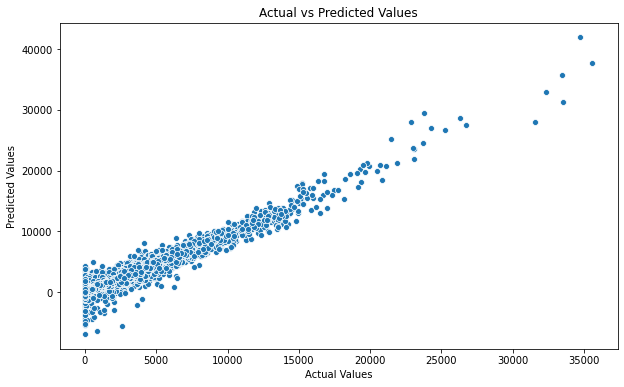

In [48]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x=y_test, y=y_pred)
ax.set(xlabel='Actual Values', ylabel='Predicted Values')
ax.set_title('Actual vs Predicted Values')

# Data Modelling - Support Vector Regression

**Hyper parameter tuning**

In [49]:
'''
reg = SVR(max_iter=10000)
parameters = {
    'kernel': ['linear'],
    'C': [100],
    'tol': [0.01]
     }

grid = GridSearchCV(clf, parameters, n_jobs=4, scoring='r2', cv=2, verbose=20)
grid.fit(X_scaled, y_scaled)
print('Best Estimator: ', grid.best_estimator_)
print('Best Score: ', grid.best_score_)
'''

"\nreg = SVR(max_iter=10000)\nparameters = {\n    'kernel': ['linear'],\n    'C': [100],\n    'tol': [0.01]\n     }\n\ngrid = GridSearchCV(clf, parameters, n_jobs=4, scoring='r2', cv=2, verbose=20)\ngrid.fit(X_scaled, y_scaled)\nprint('Best Estimator: ', grid.best_estimator_)\nprint('Best Score: ', grid.best_score_)\n"

**Modelling: Train, Test and Model Assessment**

In [50]:
## split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_scaled,test_size=test_data_size,random_state=0)
## model fitting using train data
sv_reg = SVR(kernel='linear', C=100, tol=0.01)
sv_reg.fit(X_train, y_train)
## predicting using test data
y_pred = sv_reg.predict(X_test)

**Assessing the model performance**

In [51]:
print('The model intercept: ', sv_reg.intercept_)
print('The model prediction score (r^2): ', sv_reg.score(X_test, y_test))
print('The model prediction score (adjusted r^2): ', get_adjusted_r_squared(r_sqd=sv_reg.score(X_test, y_test), 
                                                                            N=X_test.shape[0],
                                                                            p=X_test.shape[1]))
print('The model RMSE score: ', get_rmse_score(y_pred, y_test))

The model intercept:  [1196.39308467]
The model prediction score (r^2):  0.7072270178812229
The model prediction score (adjusted r^2):  0.7022885008112435
The model RMSE score:  988.1480151806065


Text(0.5, 1.0, 'Actual vs Predicted Values')

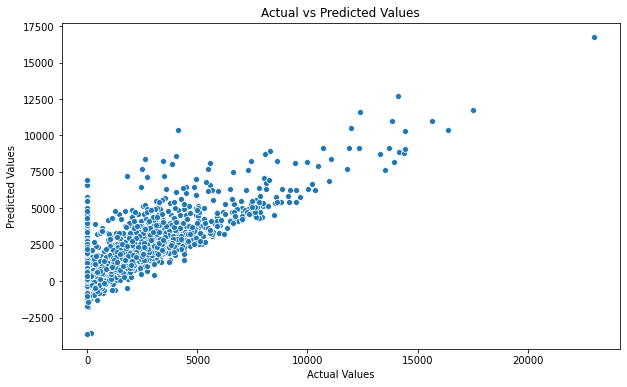

In [52]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x=y_test, y=y_pred)
ax.set(xlabel='Actual Values', ylabel='Predicted Values')
ax.set_title('Actual vs Predicted Values')

# Data Modelling - Ridge Regression

**Hyper parameter tuning**

In [49]:
'''
reg = Ridge(normalize=False,max_iter=10000,random_state=0)
parameters = {
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'alpha': [1,10,100,1000],
    'tol': [0.01,0.001,0.0001]
     }

grid = GridSearchCV(reg, parameters, n_jobs=4, scoring='r2', cv=2, verbose=20)
grid.fit(X_scaled, y_scaled)
print('Best Estimator: ', grid.best_estimator_)
print('Best Score: ', grid.best_score_)
'''

"\nreg = Ridge(normalize=False,max_iter=10000,random_state=0)\nparameters = {\n    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],\n    'alpha': [1,10,100,1000],\n    'tol': [0.01,0.001,0.0001]\n     }\n\ngrid = GridSearchCV(reg, parameters, n_jobs=4, scoring='r2', cv=2, verbose=20)\ngrid.fit(X_scaled, y_scaled)\nprint('Best Estimator: ', grid.best_estimator_)\nprint('Best Score: ', grid.best_score_)\n"

**Modelling: Train, Test and Model Assessment**

In [50]:
## split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_scaled,test_size=test_data_size,random_state=0)
## model fitting using train data
ridge_reg = Ridge(solver='auto', alpha=1, tol=0.01, normalize=False, max_iter=10000, random_state=0)
ridge_reg.fit(X_train, y_train)
## predicting using test data
y_pred = ridge_reg.predict(X_test)

**Assessing the model performance**

In [51]:
print('The model intercept: ', ridge_reg.intercept_)
print('The model prediction score (r^2): ', ridge_reg.score(X_test, y_test))
print('The model prediction score (adjusted r^2): ', get_adjusted_r_squared(r_sqd=ridge_reg.score(X_test, y_test), 
                                                                            N=X_test.shape[0],
                                                                            p=X_test.shape[1]))
print('The model RMSE score: ', get_rmse_score(y_pred, y_test))

The model intercept:  1207.5578148591142
The model prediction score (r^2):  0.7082931936004602
The model prediction score (adjusted r^2):  0.7078085827393452
The model RMSE score:  1000.6870076570267


Text(0.5, 1.0, 'Actual vs Predicted Values')

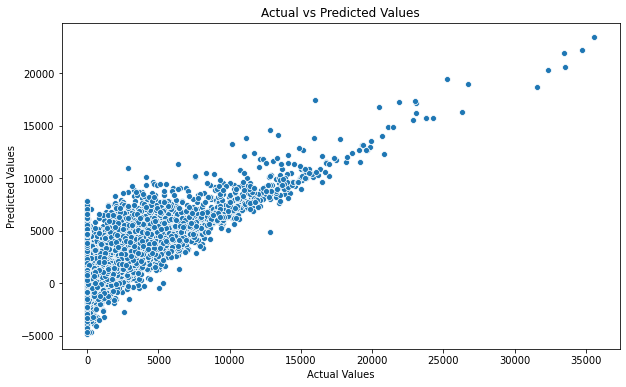

In [52]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x=y_test, y=y_pred)
ax.set(xlabel='Actual Values', ylabel='Predicted Values')
ax.set_title('Actual vs Predicted Values')

# Data Modelling - Lasso Regression

In [53]:
'''
reg = Lasso(normalize=False,max_iter=10000,random_state=0)
parameters = {
    'selection': ['cyclic','random'],
    'alpha': [1,10,100,1000],
    'tol': [0.01,0.001,0.0001],
    'positive': [True,False]
     }

grid = GridSearchCV(reg, parameters, n_jobs=4, scoring='r2', cv=2, verbose=20)
grid.fit(X_scaled, y_scaled)
print('Best Estimator: ', grid.best_estimator_)
print('Best Score: ', grid.best_score_)
'''

"\nreg = Lasso(normalize=False,max_iter=10000,random_state=0)\nparameters = {\n    'selection': ['cyclic','random'],\n    'alpha': [1,10,100,1000],\n    'tol': [0.01,0.001,0.0001],\n    'positive': [True,False]\n     }\n\ngrid = GridSearchCV(reg, parameters, n_jobs=4, scoring='r2', cv=2, verbose=20)\ngrid.fit(X_scaled, y_scaled)\nprint('Best Estimator: ', grid.best_estimator_)\nprint('Best Score: ', grid.best_score_)\n"

**Modelling: Train, Test and Model Assessment**

In [54]:
## split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_scaled,test_size=test_data_size,random_state=0)
## model fitting using train data
lasso_reg = Lasso(selection='cyclic', alpha=1, tol=0.0001, normalize=False, max_iter=10000, random_state=0)
lasso_reg.fit(X_train, y_train)
## predicting using test data
y_pred = lasso_reg.predict(X_test)

In [55]:
print('The model intercept: ', lasso_reg.intercept_)
print('The model prediction score (r^2): ', lasso_reg.score(X_test, y_test))
print('The model prediction score (adjusted r^2): ', get_adjusted_r_squared(r_sqd=lasso_reg.score(X_test, y_test), 
                                                                            N=X_test.shape[0],
                                                                            p=X_test.shape[1]))
print('The model RMSE score: ', get_rmse_score(y_pred, y_test))

The model intercept:  1207.5769465496398
The model prediction score (r^2):  0.7081764209472013
The model prediction score (adjusted r^2):  0.7076916160923405
The model RMSE score:  1000.8872792695611


Text(0.5, 1.0, 'Actual vs Predicted Values')

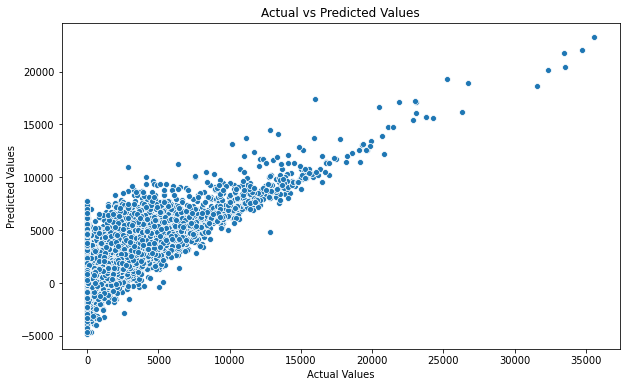

In [56]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x=y_test, y=y_pred)
ax.set(xlabel='Actual Values', ylabel='Predicted Values')
ax.set_title('Actual vs Predicted Values')

# Model Performance Summary

<table style="width:50%">
<tr>
<th>Model Name</th>
<th>RMSE</th>
<th>R^2</th>
<th>Adjusted R^2</th>    
</tr>

<tr>
<td>Polynomial Regression</td>
<td>458.87</td>
<td>0.94</td>
<td>0.93</td>
</tr>

<tr>
<td>Linear Regression</td>
<td>1000.69</td>
<td>0.708</td>
<td>0.707</td>
</tr>

<tr>
<td>Lasso Regression</td>
<td>1000.89</td>
<td>0.708</td>
<td>0.707</td>
</tr>

<tr>
<td>Ridge Regression</td>
<td>1207.56</td>
<td>0.708</td>
<td>0.707</td>
</tr>

<tr>
<td>Support Vector Regression</td>
<td>1023.00</td>
<td>0.707</td>
<td>0.702</td>
</tr>

</table>

# Predicting the fate of currently active loans

In [57]:
'''
## preprocessing the data
loan_data_final_predict['issue_d'] = (pd.to_datetime(loan_data_final_predict['issue_d']).dt.year).astype(int)
loan_data_final_predict['emp_length'].fillna(value=0,inplace=True)
loan_data_final_predict['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
loan_data_final_predict['emp_length'] = loan_data_final_predict['emp_length'].astype(int)
loan_data_final_predict['emp_length'].replace(to_replace=0, value=np.nan, inplace=True)
## dropping columns not needed
loan_data_final_predict.drop(cols_to_be_dropped, axis=1, inplace=True)
## temporary step
for feature in temp_cols_imputed:
    loan_data_final_predict[feature] = impute_by_constant(loan_data_final_predict, feature, 
                                                          loan_data_final_predict[feature].median())
loan_data_final_predict.drop(temp_cols_dropped, axis=1, inplace=True)
## missing value imputation -> constant(zero), mean, median
for feature in cols_for_zero_imputation:
    loan_data_final_predict[feature] = impute_by_constant(loan_data_final_predict, feature, 0)
for feature in cols_for_median_imputation:
    loan_data_final_predict[feature] = impute_by_constant(loan_data_final_predict, feature, 
                                                          loan_data[feature].median())
## categorical value encoding
for feature in loan_data_final_predict.columns:
    if loan_data_final_predict[feature].dtype == 'object':
        loan_data_final_predict[feature] = encode_categorical_variable(loan_data_final_predict, feature)
## missing value imputation -> knn
for feature in cols_for_knn_imputation:
    loan_data_final_predict[feature] = impute_by_constant(loan_data_final_predict, feature, 
                                                          loan_data_final_predict[feature].mode().get(0))
## missing value imputation -> constant (categorical)
loan_data_final_predict['verification_status_joint'] = impute_by_constant(loan_data_final_predict, 
                                                                          'verification_status_joint', 
                                                                          'Not Applicable')
## categorical value encoding
#loan_data_final_predict = scale_variable(loan_data_final_predict, 'loan_type')
scaler = StandardScaler()
scaler.fit(loan_data_final_predict)
loan_data_final_predict = pd.DataFrame(scaler.transform(loan_data_final_predict), 
                                       columns=loan_data_final_predict.columns)
## predict
y_final_pred = lg_clf.predict(loan_data_final_predict)
## merge predicted values with dataset
loan_data_final_predict['loan_status'] = pd.Series(y_final_pred)
'''

"\n## preprocessing the data\nloan_data_final_predict['issue_d'] = (pd.to_datetime(loan_data_final_predict['issue_d']).dt.year).astype(int)\nloan_data_final_predict['emp_length'].fillna(value=0,inplace=True)\nloan_data_final_predict['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)\nloan_data_final_predict['emp_length'] = loan_data_final_predict['emp_length'].astype(int)\nloan_data_final_predict['emp_length'].replace(to_replace=0, value=np.nan, inplace=True)\n## dropping columns not needed\nloan_data_final_predict.drop(cols_to_be_dropped, axis=1, inplace=True)\n## temporary step\nfor feature in temp_cols_imputed:\n    loan_data_final_predict[feature] = impute_by_constant(loan_data_final_predict, feature, \n                                                          loan_data_final_predict[feature].median())\nloan_data_final_predict.drop(temp_cols_dropped, axis=1, inplace=True)\n## missing value imputation -> constant(zero), mean, median\nfor feature in cols_

In [58]:
'''
## write prdicted values to output file
loan_data_final_predict[loan_data_final_predict['loan_status'] == 0].to_csv('predicted_bad_loans.csv', index=False) 
'''

"\n## write prdicted values to output file\nloan_data_final_predict[loan_data_final_predict['loan_status'] == 0].to_csv('predicted_bad_loans.csv', index=False) \n"